#  Presentacion de la TS9
## Francisco Pereira

### Filtro IIR:

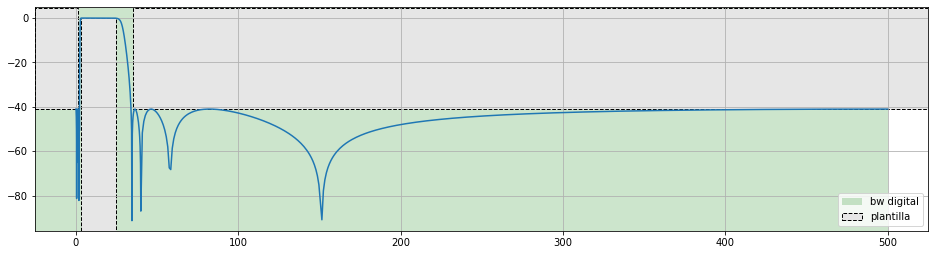

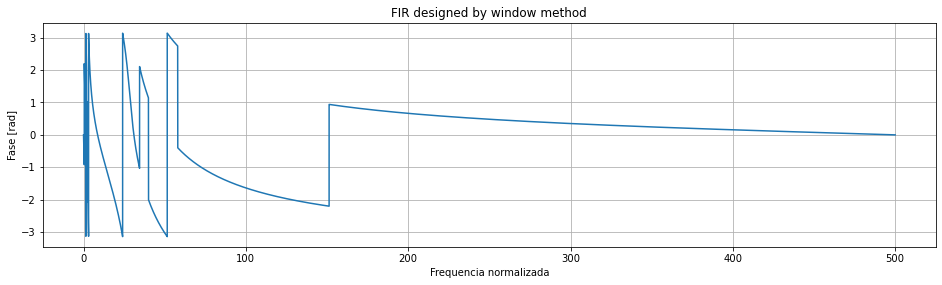

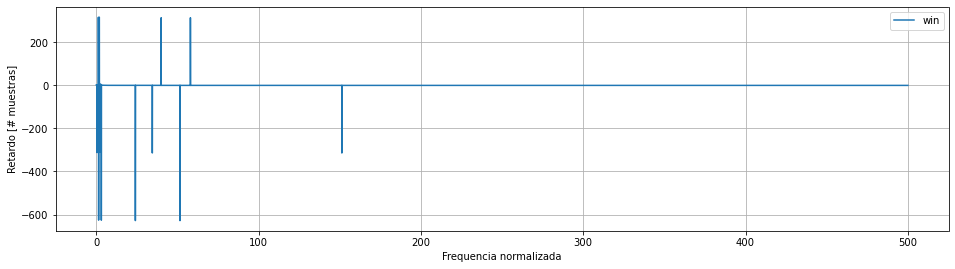

In [7]:
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from splane import plot_plantilla

##para el retardo de grupo
def group_delay(ww, phase):
    
    groupDelay = -np.diff(phase)/np.diff(ww)
    
    return(np.append(groupDelay, groupDelay[-1]))

fs = 1000 # Hz
nyq_frec = fs / 2

ripple = 0.1 # dB
atenuacion = 41 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

worN=int(5*10e3)

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

# Si bien me piden 40dB de atenuacion en las ws, lo que hago es atenuar 41 subir el grafico en 1
# db, asi nunca entra el filtro en las zonas prohibidas
bp_sos_butter = sig.iirdesign([wp1, wp2], [ws1, ws2], ripple, atenuacion, False, 'cheby2', 'sos', fs)
w_rad  = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) ) / nyq_frec * np.pi

_, butter = sig.sosfreqz(bp_sos_butter, w_rad)
ww, hh = sig.sosfreqz(bp_sos_butter, worN,False,fs)

# Levanto el grafico en 1dB
plt.subplot(3, 1, 1)
plt.gcf().set_size_inches(16, 14)
plt.plot((w_rad/np.pi)*500, 20*np.log10(np.abs(butter)))
plt.grid()

# Plantilla
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec,ripple = ripple ,
               fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)


##fase
plt.subplot(3, 1, 2)
plt.gcf().set_size_inches(16, 14)
plt.plot(ww, np.angle(hh) )

plt.title('FIR designed by window method')
plt.xlabel('Frequencia normalizada')
plt.ylabel('Fase [rad]')
plt.grid(which='both', axis='both')
plt.show()

#Retardo

phase_win = np.angle(hh)
gd_win = group_delay(ww, phase_win)

plt.figure()
plt.subplot(3, 1, 3)
plt.gcf().set_size_inches(16, 14)
plt.plot(ww, gd_win , label='win')
plt.xlabel('Frequencia normalizada')
plt.ylabel('Retardo [# muestras]')
plt.grid(which='both', axis='both')

axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

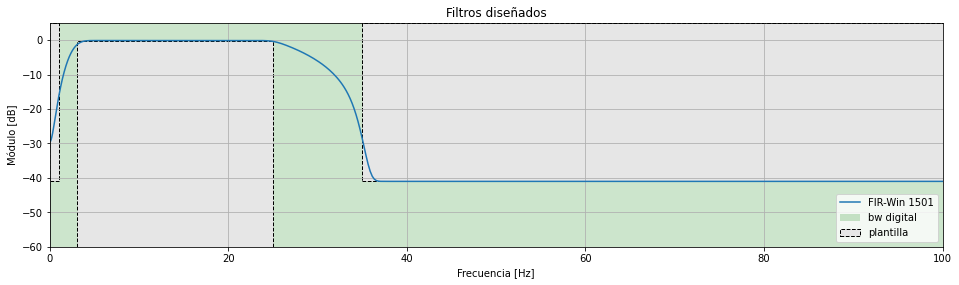

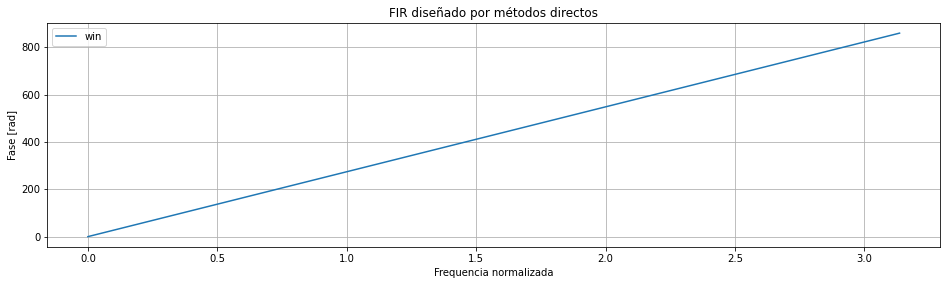

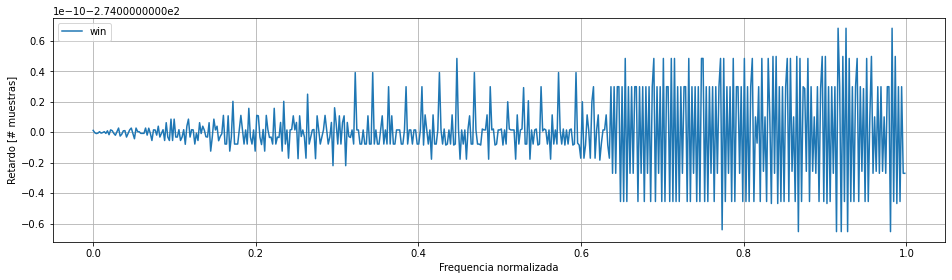

In [8]:
cant_coeficientes = 1501

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

num_win = sig.firwin2(cant_coeficientes, frecs, gains , window='blackmanharris' )

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_win, den, w)
ww_w, hh_w = sig.freqz(num_win, den)
ww = ww_w / np.pi

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.figure()
plt.subplot(3, 1, 1)
plt.gcf().set_size_inches(16, 14)
plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , 
               fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

#Fase
plt.figure()
plt.subplot(3, 1, 2)
plt.gcf().set_size_inches(16, 14)
phase_win = np.unwrap(np.angle(hh_w))
plt.plot(ww_w, phase_win, label='win')
plt.title('FIR diseñado por métodos directos')
plt.xlabel('Frequencia normalizada')
plt.ylabel('Fase [rad]')
plt.grid(which='both', axis='both')

axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

#Retardo
phase_win = np.unwrap(np.angle(hh_w))
gd_win = group_delay(ww_w , phase_win)

plt.figure()
plt.subplot(3, 1, 3)
plt.gcf().set_size_inches(16, 14)
plt.plot(ww, gd_win , label='win')
plt.xlabel('Frequencia normalizada')
plt.ylabel('Retardo [# muestras]')
plt.grid(which='both', axis='both')

axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

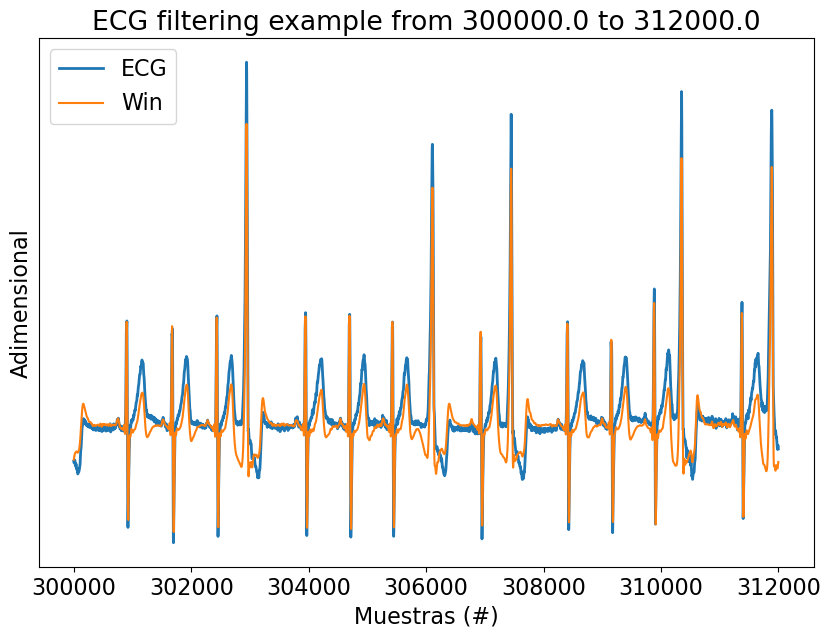

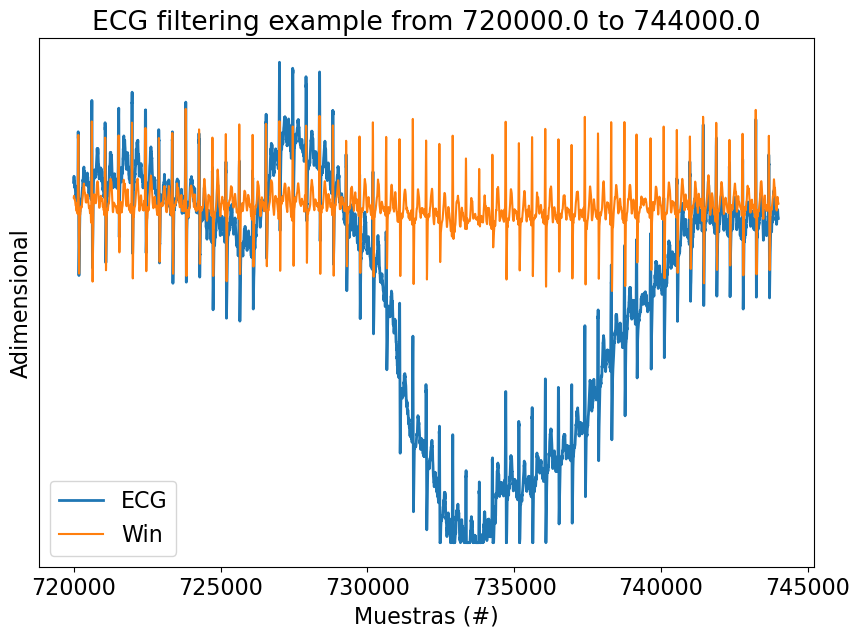

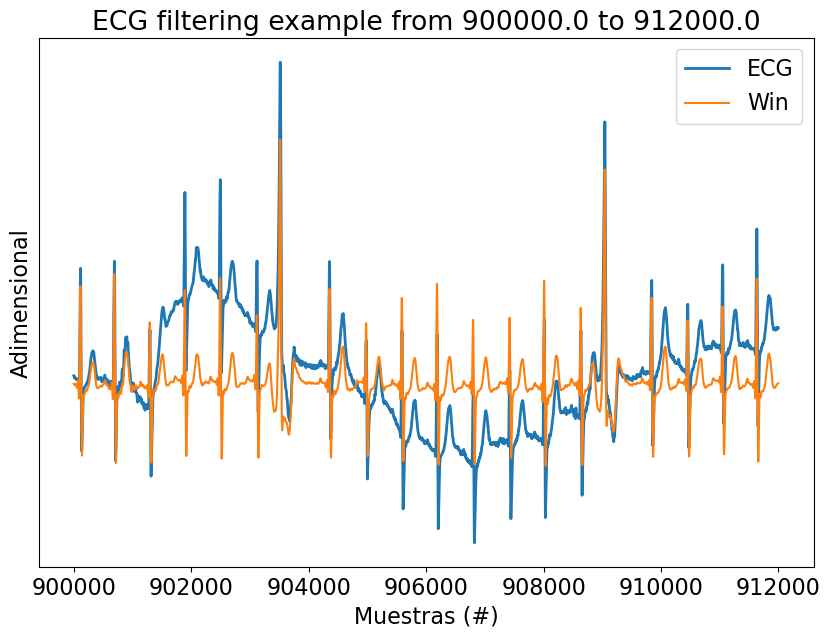

In [10]:
fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

mat_struct = sio.loadmat('ecg.mat')
ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)

# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 750


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

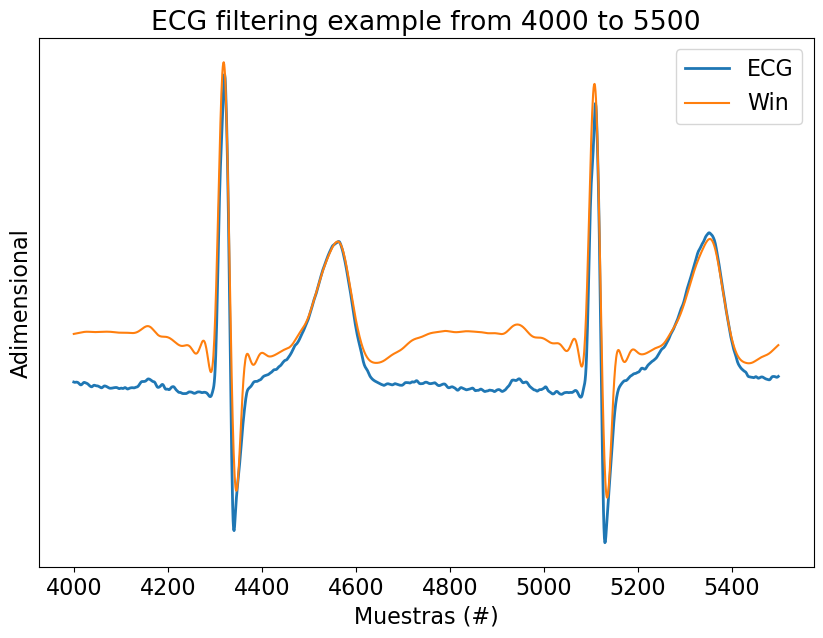

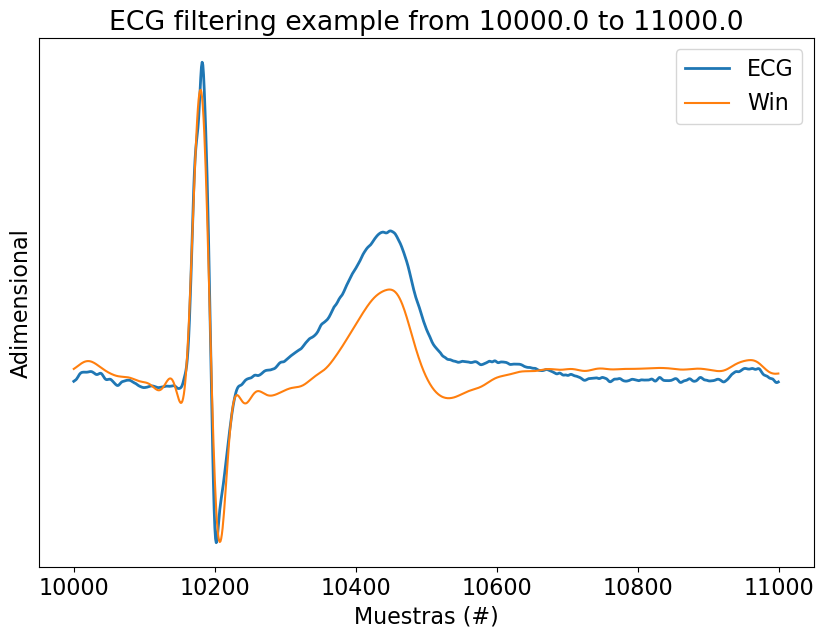

In [11]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

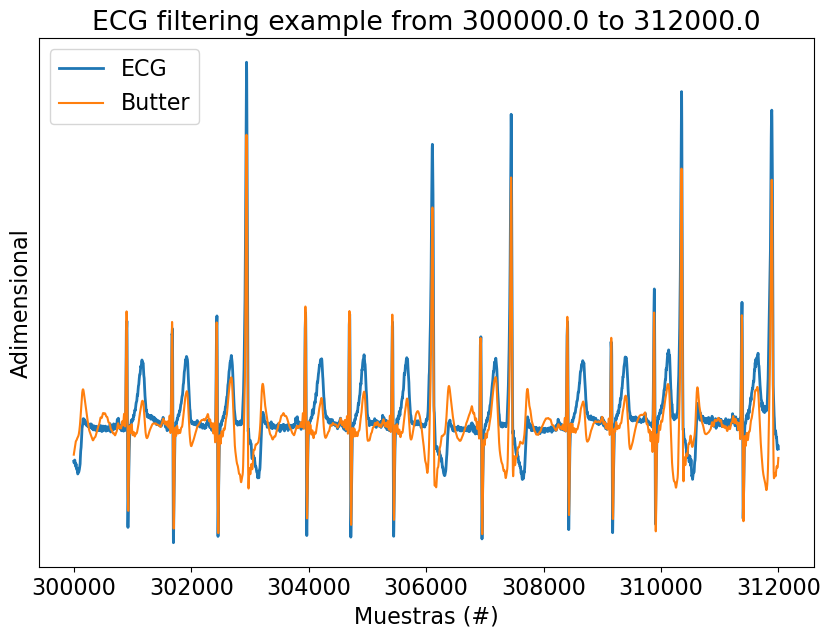

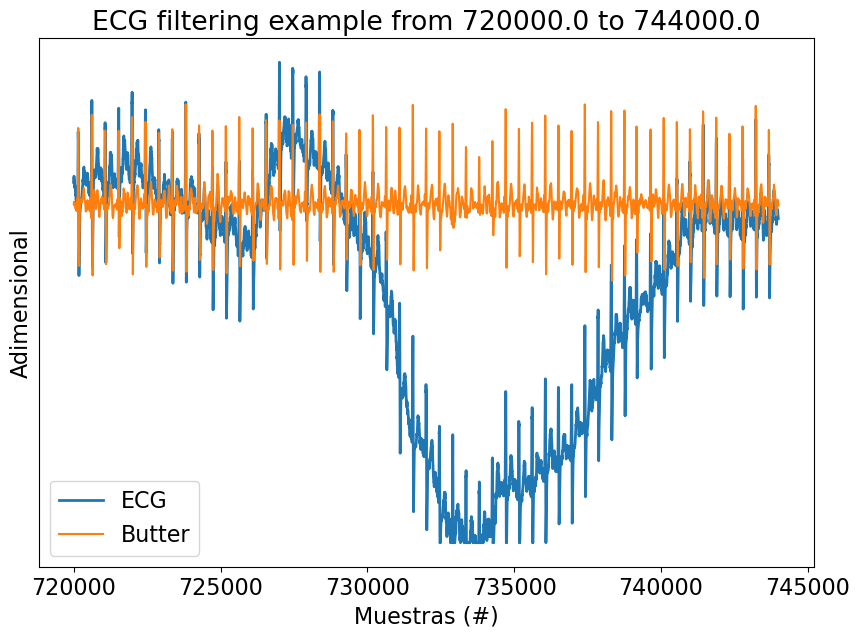

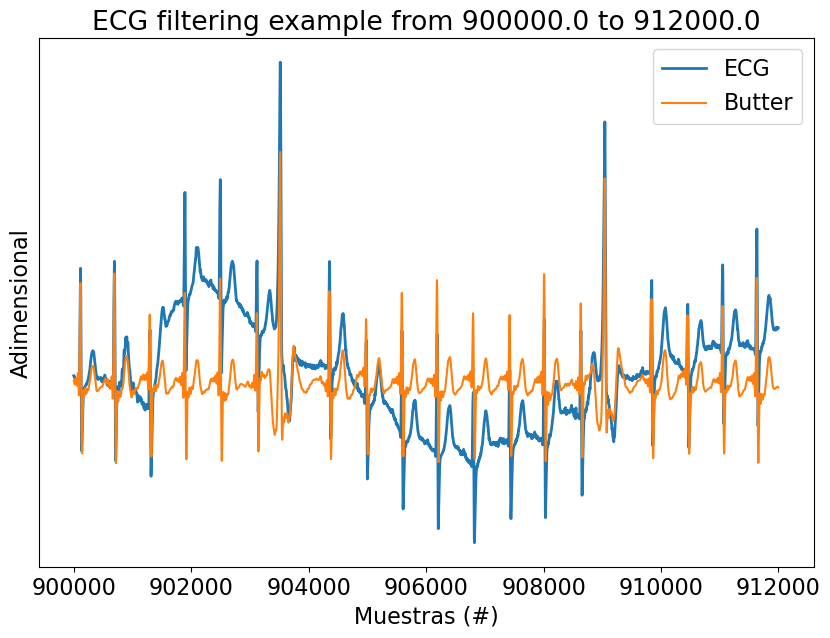

In [12]:
ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

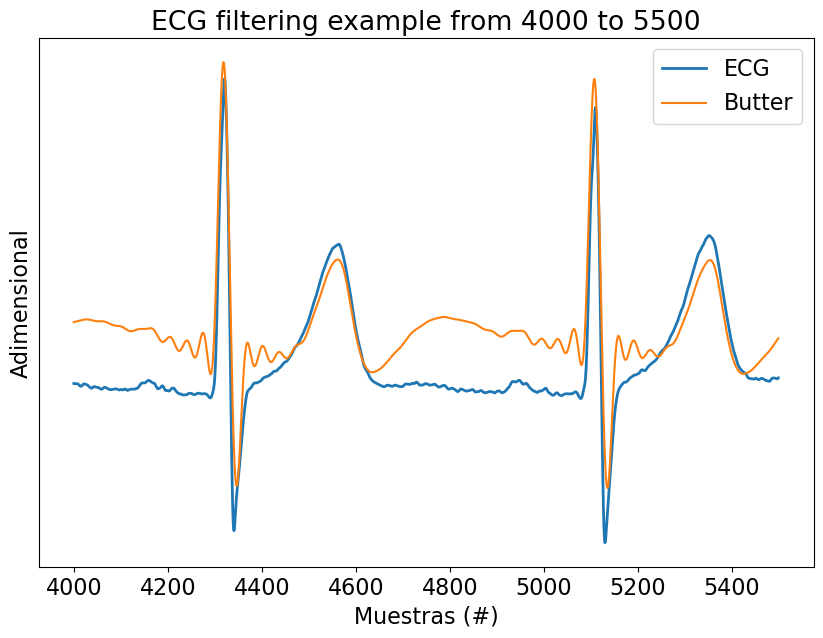

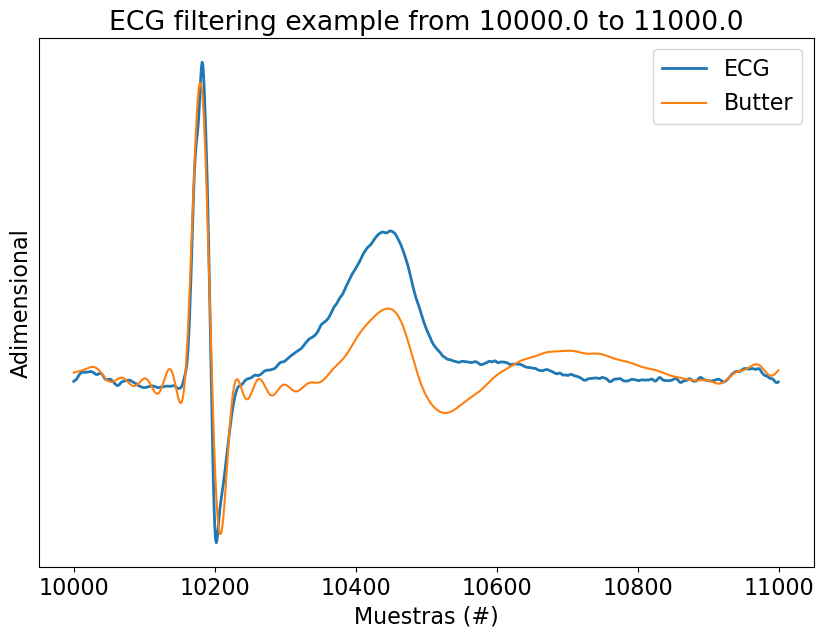

In [13]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()